<a href="https://colab.research.google.com/github/eunicebalicanta/portfolio-optimization-py/blob/main/portfolio_optimization_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization and Asset Allocation Visualization

###Objective
This project provides a hands-on approach to optimizing a portfolio of stocks, exchange-traded funds (ETFs), and foreign exchange (FX) spot rates, based on various financial metrics. The aim is to help investors and analysts maximize returns while managing risks effectively, using different optimization strategies. The user inputs tickers (up to 50), and the project pulls relevant financial data to generate actionable insights, including visualizations of asset allocations and portfolio performance. This process is further enhanced by historical backtesting and correlation analysis.

###Data Collection
The historical price data of the selected tickers is collected from Yahoo! Finance for a specified four-year time frame, from 2020-01-01 to 2024-01-01. This data includes daily stock prices, ETFs, and FX spot rates, which are then processed to compute daily returns. The code supports multiple types of tickers, including:

- Stocks (e.g., AAPL, AMZN)
- ETFs (e.g., VOO, SPY)
- FX Spot Rates (e.g., JPY=X for Japanese Yen)

###Financial Models
The project utilizes several optimization techniques, including:

- Sharpe Ratio: Maximizes return per unit of risk by considering the excess return

- Kelly Criterion: Determines the optimal proportion of the portfolio to invest in each asset, aiming to maximize the expected logarithm of wealth

- Conditional Value at Risk (CVaR): Minimizes potential losses in adverse scenarios, enhancing overall risk management

- Risk Parity: Balances risk across the portfolio to ensure equal contributions to total risk from each asset

###Backtesting Performance
To assess the effectiveness of these models, the portfolio is backtested using an initial budget of $100,000. The backtesting process evaluates how each optimized portfolio would have performed over time. This includes:

- Plotting Cumulative Returns: The value of the portfolio is tracked from the start to the end of the test period

- Comparison of Models: The portfolio's growth under different optimization strategies (Sharpe Ratio, Kelly, CVaR, Risk Parity) is visualized to identify which model yields the best results

###Efficient Frontier Visualization
The Efficient Frontier represents the set of optimal portfolios offering the highest expected return for a defined level of risk. The visualization uses the mean-variance optimization framework and includes:

- Volatility vs. Return: Portfolios are plotted on a scatter plot with expected return on the y-axis and portfolio volatility (standard deviation) on the x-axis

- Sharpe Ratio Visualization: The efficient frontier is color-coded to highlight portfolios based on their Sharpe Ratios. Higher Sharpe Ratios are shown in brighter colors

- Optimal Portfolio Markers: A star marks the most optimal portfolio based on the highest Sharpe Ratio.
An 'X' indicates other portfolios with lower risk at various volatility levels

###Correlation Heatmap:
In addition to portfolio optimization, the code generates a heatmap based on the correlation matrix of the returns. This helps investors understand how the selected assets move in relation to one another. The correlation matrix reveals the degree to which asset prices are correlated:

- Correlation Coefficients: Values close to 1 indicate a strong positive correlation, while values close to -1 indicate a strong negative correlation. A value of 0 implies no correlation

- Interpretation: Highly correlated assets tend to move together, while uncorrelated or negatively correlated assets provide diversification benefits. The heatmap visually represents these relationships, aiding in diversification strategy

#### Asset Allocation by Industry:
To provide a broader understanding of the portfolio's composition, the code generates a pie chart showing asset allocation by industry. This feature utilizes Yahoo! Finance's industry classifications to break down the investments by sectors


In [ ]:
# Install libraries
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install yfinance
!pip install seaborn
!pip install scipy

print("All libraries installed")

All libraries installed


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf
import requests
import seaborn as sns
import scipy.optimize as sco

print("All libraries imported")

All libraries imported


In [ ]:
# Retrieve Yahoo! Finance ticker information
def get_asset_data(tickers, start_date, end_date):
    asset_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return asset_data

def get_company_names(tickers):
    names = {}
    for ticker in tickers:
        try:
            name = yf.Ticker(ticker).info['longName']
            names[ticker] = name
        except KeyError:
            names[ticker] = "N/A"
    return names

#### Mean-Variance Portfolio:
The Mean-Variance Portfolio theory,  focuses on the trade-off between risk and return in investment decisions. This approach aims to construct an optimal portfolio by considering the expected returns (mean) and the associated risks (variance) of the assets. The key concept is the Efficient Frontier, which represents a set of optimal portfolios that offer the highest expected return for a given level of risk. Investors can select portfolios along this frontier based on their risk tolerance.

#### Maximum Sharpe Ratio Portfolio:
This is a specific application of the mean-variance optimization framework. It seeks to maximize the Sharpe Ratio, which measures the risk-adjusted return of a portfolio. The Sharpe Ratio is calculated as the difference between the portfolio return and the risk-free rate, divided by the portfolio's standard deviation.

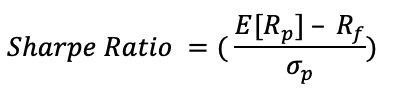

In [ ]:
# Define functions for Maximum Sharpe Ratio
def calculate_daily_returns(asset_data):
    return asset_data.pct_change().dropna()

def portfolio_performance(weights, returns):
    portfolio_return = np.dot(weights, returns.mean()) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std_dev

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    portfolio_return, portfolio_std_dev = portfolio_performance(weights, returns)
    return -(portfolio_return - risk_free_rate) / portfolio_std_dev

def optimize_portfolio_sharpe(returns):
    num_assets = len(returns.columns)
    best_sharpe = -np.inf
    best_weights = None
    for _ in range(10000):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        sharpe = -negative_sharpe_ratio(weights, returns)
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_weights = weights
    return best_weights


#### Risk Parity:

This investment strategy aims to allocate risk evenly across all assets in a portfolio rather than allocating capital equally. The underlying principle is that each asset should contribute equally to the total risk of the portfolio, leading to better diversification and improved risk-adjusted returns.

In [ ]:
# Define functions for Risk Parity
def risk_contribution(weights, cov_matrix):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contributions = np.dot(cov_matrix, weights) / portfolio_volatility
    risk_contributions = weights * marginal_contributions
    return risk_contributions

def risk_parity_objective(weights, cov_matrix):
    risk_contributions = risk_contribution(weights, cov_matrix)
    return np.sum((risk_contributions - np.mean(risk_contributions))**2)

def optimize_portfolio_risk_parity(returns):
    cov_matrix = returns.cov() * 252
    num_assets = len(returns.columns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = np.array(num_assets * [1. / num_assets])
    result = sco.minimize(risk_parity_objective, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x if result.success else initial_guess

#### Conditional Value at Risk (CVaR)

Also known as Expected Shortfall, CVaR is a risk assessment measure and strategy that focuses on calculating tail loss. By focusing on the worst p% of cases, where p is the confience level (95-99%), this provides asset allocation that can better mitigate extreme drawdowns and volatility.

In [ ]:
# Define functions for Conditional Value at Risk (CVaR)
def optimize_portfolio_cvar(returns, alpha=0.05):
    def cvar_objective(weights):
        portfolio_returns = returns.dot(weights)
        var = np.percentile(portfolio_returns, 100 * (1 - alpha))
        cvar = portfolio_returns[portfolio_returns <= var].mean()
        return -cvar
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))
    initial_guess = np.array(len(returns.columns) * [1. / len(returns.columns)])
    result = sco.minimize(cvar_objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x if result.success else initial_guess

 #### Kelly Criterion:

The Kelly Criterion is a mathematical formula designed to determine the optimal size of a bet or investment allocation that maximizes the expected logarithm of wealth over the long term. By balancing risk and reward, it aims to maximize capital growth. Unlike Risk Parity and Conditional Value at Risk, the criterion focuses on the relationship between expected returns and the probabilities of winning and losing, emphasizing the optimal growth rate of capital rather than specifically managing losses.

Capital (or risk) per investment is simplified as "C" in the formula below:

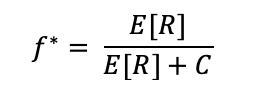

In [ ]:
# Calculate Kelly Criterion
def optimize_portfolio_kelly(returns):
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    weights = np.dot(inv_cov_matrix, mean_returns) / np.dot(mean_returns.T, np.dot(inv_cov_matrix, mean_returns))
    weights = np.maximum(weights, 0)
    return weights / np.sum(weights)

In [ ]:
# Plot Efficient Frontier and Portfolio Asset Allocations
def plot_portfolio_weights(weights, tickers, model):
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140)
    plt.title(f'{model} Optimal Weights')
    plt.axis('equal')
    plt.show()

def get_company_industry(tickers):
    industries = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            industries[ticker] = info.get('industry', 'Unknown')
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            industries[ticker] = 'Error'
    return industries

def plot_asset_allocation(industries):
    industry_counts = {}
    for industry in industries.values():
        if industry in industry_counts:
            industry_counts[industry] += 1
        else:
            industry_counts[industry] = 1
    labels = industry_counts.keys()
    sizes = industry_counts.values()
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Asset Allocation by Industry')
    plt.show()

In [ ]:
# Perform backtesting for each optimal portfolio
def backtest_portfolio(weights, returns, initial_investment=100000):
    portfolio_returns = (returns @ weights).dropna()
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    portfolio_value = initial_investment * (1 + cumulative_returns)
    return portfolio_value
def currency_formatter(x, pos):
    return f'${x:,.0f}'

Enter up to 50 stock, ETF, or FX spot rate tickers as listed on Yahoo! Finance (for ex. AAPL, VFV.TO, JPY=X)
Current tickers: None
Ticker: JPM
Current tickers: JPM
Ticker: LLY
Current tickers: JPM, LLY
Ticker: AVGO
Current tickers: JPM, LLY, AVGO
Ticker: KGC
Current tickers: JPM, LLY, AVGO, KGC
Ticker: XOM
Current tickers: JPM, LLY, AVGO, KGC, XOM
Ticker: CRM
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM
Ticker: AAPL
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL
Ticker: NVDA
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL, NVDA
Ticker: AMZN
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL, NVDA, AMZN
Ticker: WMT
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL, NVDA, AMZN, WMT
Ticker: ULTA
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL, NVDA, AMZN, WMT, ULTA
Ticker: MA
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL, NVDA, AMZN, WMT, ULTA, MA
Ticker: COST
Current tickers: JPM, LLY, AVGO, KGC, XOM, CRM, AAPL, NVDA, AMZN, WMT, ULTA, MA, COST
Ticker: stop


[*********************100%***********************]  13 of 13 completed


Optimizing portfolio using Mean-Variance...


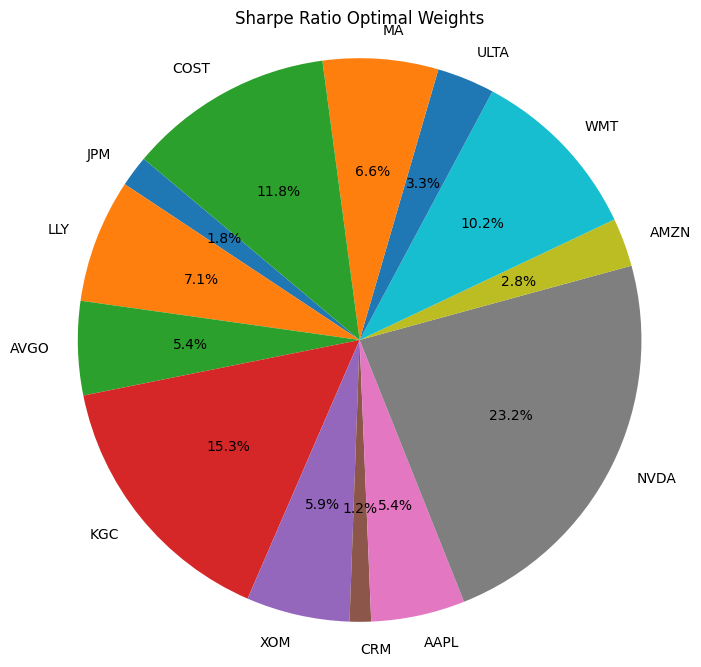

Optimizing portfolio using Risk Parity...


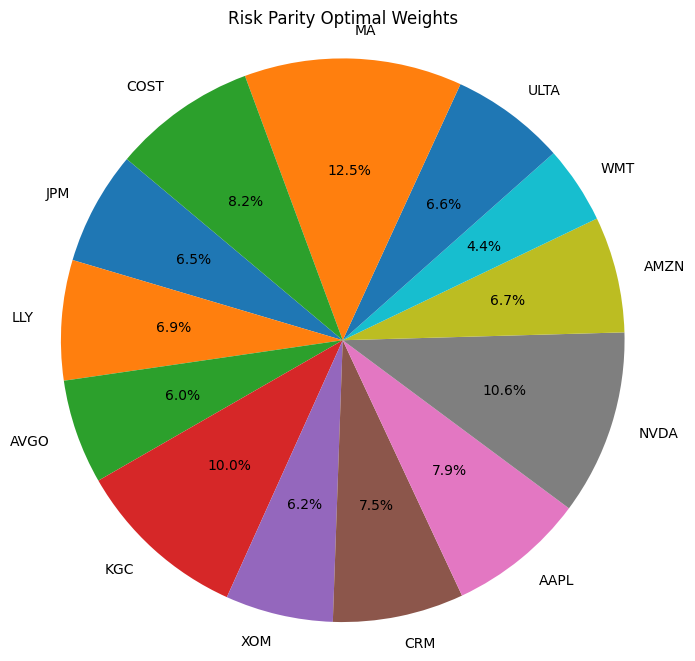

Optimizing portfolio using Conditional Value at Risk...


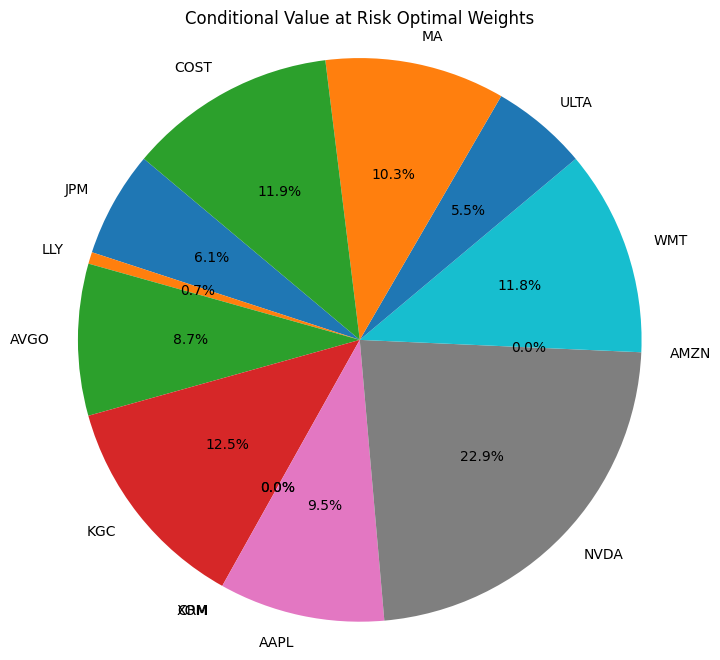

Optimizing portfolio using Kelly Criterion...


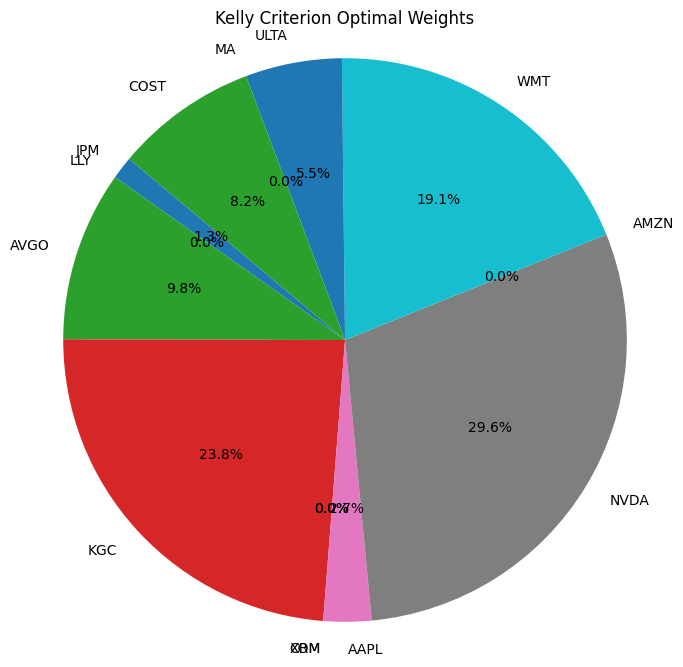

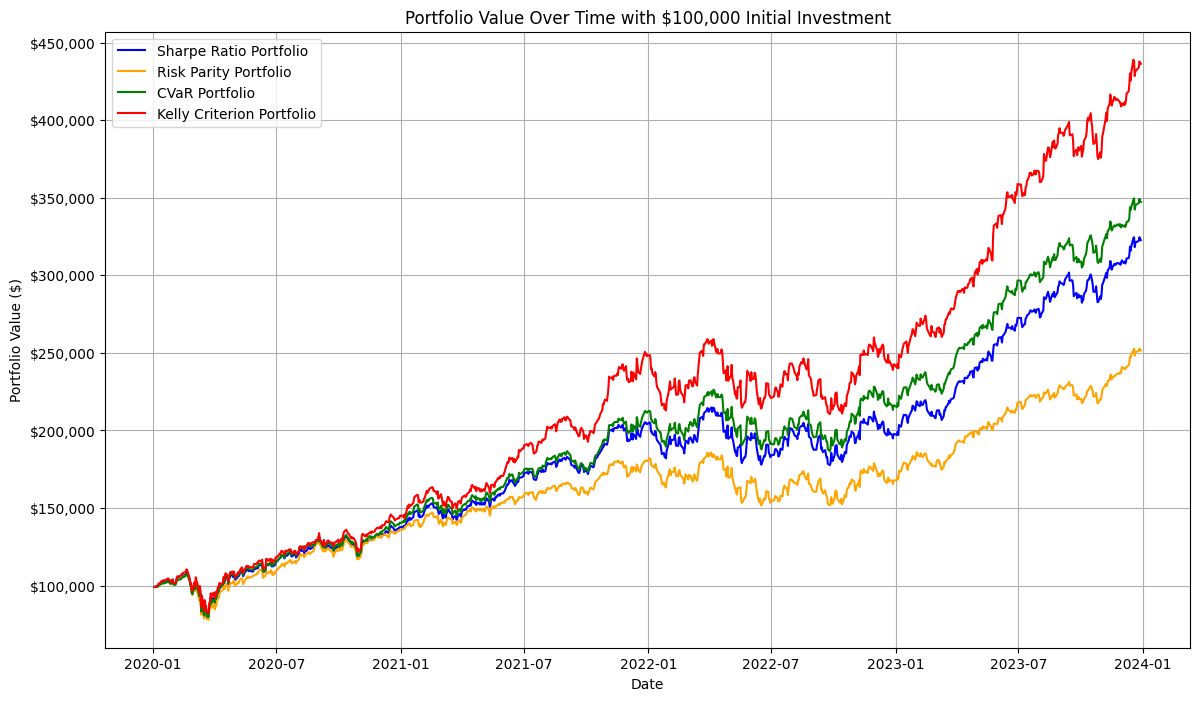

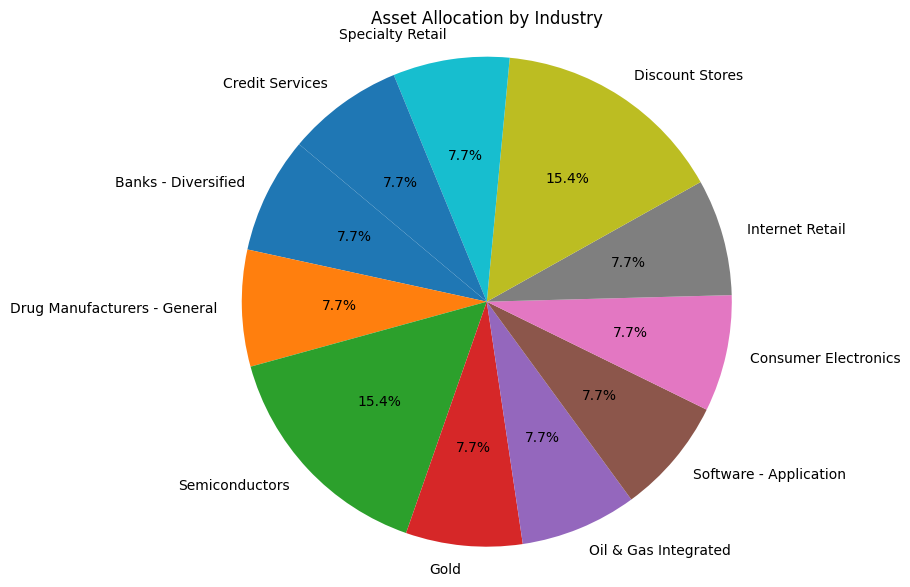

Plotting Efficient Frontier...


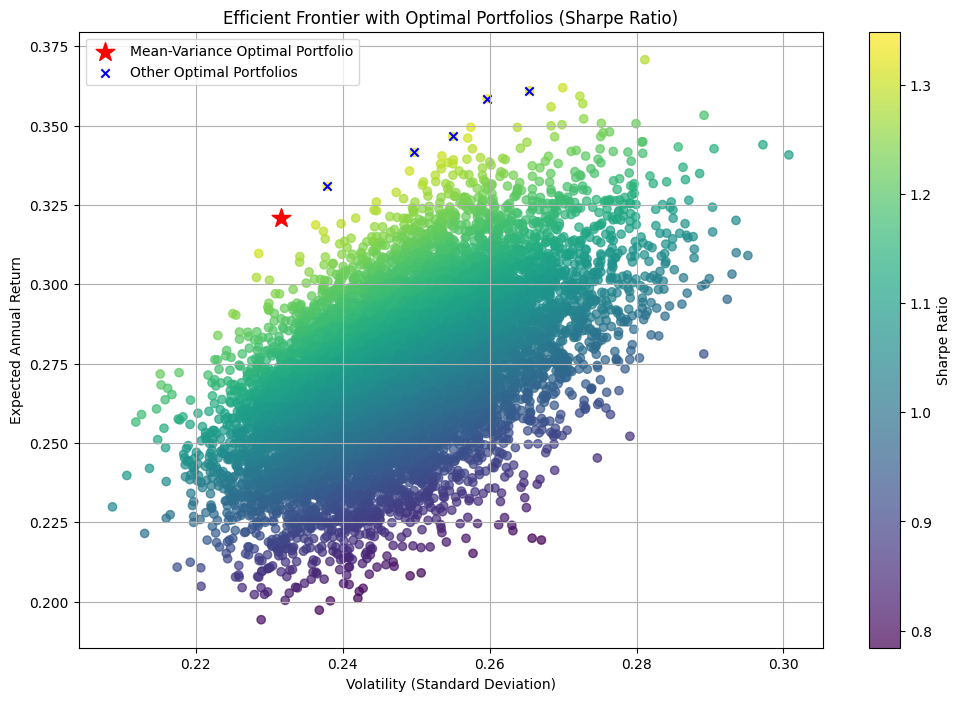

Plotting Correlation Heatmap...


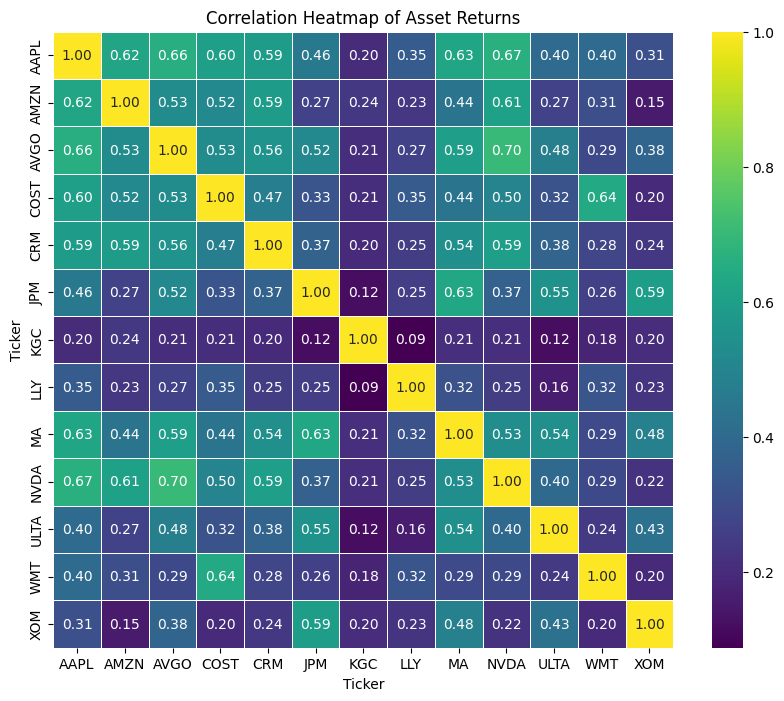

In [ ]:
# Plot Efficient Frontier and Backtesting Time Series Analysis
def plot_efficient_frontier(returns, weights_mean_variance, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))
    weights_list = []
    for i in range(num_portfolios):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std_dev = portfolio_performance(weights, returns)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = (portfolio_return - 0.01) / portfolio_std_dev
        weights_list.append(weights)
    mv_return, mv_std_dev = portfolio_performance(weights_mean_variance, returns)
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.7)
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.scatter(mv_std_dev, mv_return, color='red', marker='*', s=200, label='Mean-Variance Optimal Portfolio')
    plt.scatter(results[1, results[2].argsort()[-5:]], results[0, results[2].argsort()[-5:]], color='blue', marker='x', label='Other Optimal Portfolios')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Annual Return')
    plt.title('Efficient Frontier with Optimal Portfolios (Sharpe Ratio)')
    plt.grid()
    plt.legend()
    plt.show()

def plot_correlation_heatmap(returns):
    correlation_matrix = returns.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Asset Returns")
    plt.show()

def main():
    tickers = []
    print("Enter up to 50 stock, ETF, or FX spot rate tickers as listed on Yahoo! Finance (for ex. AAPL, VFV.TO, JPY=X)")
    print("Type 'stop' to finish.")
    while len(tickers) < 50:
        print(f"Current tickers: {', '.join(tickers) if tickers else 'None'}")
        user_input = input("Ticker: ").strip().upper()
        if user_input.lower() == 'stop':
            break
        if user_input and user_input not in tickers:
            tickers.append(user_input)
        else:
            print("Invalid input. Please enter a new ticker symbol or type 'stop' to finish.")

    start_date = '2020-01-01'
    end_date = '2024-01-01'
    asset_data = get_asset_data(tickers, start_date, end_date)
    returns = calculate_daily_returns(asset_data)
    company_names = get_company_names(tickers)

    print("Optimizing portfolio using Mean-Variance...")
    weights_sharpe = optimize_portfolio_sharpe(returns)
    plot_portfolio_weights(weights_sharpe, tickers, 'Sharpe Ratio')
    cumulative_value_sharpe = backtest_portfolio(weights_sharpe, returns)

    print("Optimizing portfolio using Risk Parity...")
    weights_risk_parity = optimize_portfolio_risk_parity(returns)
    plot_portfolio_weights(weights_risk_parity, tickers, 'Risk Parity')
    cumulative_value_risk_parity = backtest_portfolio(weights_risk_parity, returns)

    print("Optimizing portfolio using Conditional Value at Risk...")
    weights_cvar = optimize_portfolio_cvar(returns)
    plot_portfolio_weights(weights_cvar, tickers, 'Conditional Value at Risk')
    cumulative_value_cvar = backtest_portfolio(weights_cvar, returns)

    print("Optimizing portfolio using Kelly Criterion...")
    weights_kelly = optimize_portfolio_kelly(returns)
    plot_portfolio_weights(weights_kelly, tickers, 'Kelly Criterion')
    cumulative_value_kelly = backtest_portfolio(weights_kelly, returns)

    plt.figure(figsize=(14, 8))
    plt.plot(cumulative_value_sharpe, label='Sharpe Ratio Portfolio', color='blue')
    plt.plot(cumulative_value_risk_parity, label='Risk Parity Portfolio', color='orange')
    plt.plot(cumulative_value_cvar, label='CVaR Portfolio', color='green')
    plt.plot(cumulative_value_kelly, label='Kelly Criterion Portfolio', color='red')
    plt.title('Portfolio Value Over Time with $100,000 Initial Investment')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(currency_formatter))
    plt.legend()
    plt.grid()
    plt.show()

    industries = get_company_industry(tickers)
    plot_asset_allocation(industries)

    print("Plotting Efficient Frontier...")
    plot_efficient_frontier(returns, weights_sharpe)

    print("Plotting Correlation Heatmap...")
    plot_correlation_heatmap(returns)

if __name__ == "__main__":
    main()